In [1]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
import librosa
import librosa.display
from IPython.display import Audio
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
import librosa
import librosa.display
from IPython.display import Audio
import warnings
warnings.filterwarnings('ignore')
import librosa

# List to store datasets
dataset = []

# Directories for song and speech
directories = {
    "Song": "/kaggle/input/audio-files/Audio_Song_Actors_01-24/",
    "Speech": "/kaggle/input/audio-files/Audio_Speech_Actors_01-24/"
}

# Load audio files
for data_type, base_dir in directories.items():
    print(f"\nLoading {data_type} data from: {base_dir}")
    
    for i in range(1, 25):  # Actor_01 to Actor_24
        actor_folder = f'Actor_{i:02d}'
        actor_path = os.path.join(base_dir, actor_folder)
        
        if not os.path.exists(actor_path):
            print(f" - Folder not found: {actor_path}, skipping.")
            continue
        
        for file_name in os.listdir(actor_path):
            if file_name.endswith('.wav'):
                file_path = os.path.join(actor_path, file_name)
                audio, sr = librosa.load(file_path, sr=None)
                dataset.append({
                    "audio": audio,
                    "sr": sr,
                    "actor": actor_folder,
                    "filename": file_name,
                    "type": data_type
                })

    # Get the first file from Actor_01 in this category
    first_file = next(item for item in dataset if item["actor"] == "Actor_01" and item["type"] == data_type)
    print(f"\nFirst file in {data_type}:")
    print(" - Actor folder:", first_file["actor"])
    print(" - Filename:", first_file["filename"])
    print(" - Audio shape:", first_file["audio"].shape)
    print(" - Sampling rate:", first_file["sr"])

# Final summary
print(f"\n✅ Total audio files loaded: {len(dataset)}")



Loading Song data from: /kaggle/input/audio-files/Audio_Song_Actors_01-24/
 - Folder not found: /kaggle/input/audio-files/Audio_Song_Actors_01-24/Actor_18, skipping.

First file in Song:
 - Actor folder: Actor_01
 - Filename: 03-02-06-01-02-01-01.wav
 - Audio shape: (206606,)
 - Sampling rate: 48000

Loading Speech data from: /kaggle/input/audio-files/Audio_Speech_Actors_01-24/

First file in Speech:
 - Actor folder: Actor_01
 - Filename: 03-01-02-01-02-02-01.wav
 - Audio shape: (166567,)
 - Sampling rate: 48000

✅ Total audio files loaded: 2452


In [3]:
import os

paths = []
labels = []

# Traverse through all files under the input directory
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        if filename.endswith('.wav'):
            # Full path to audio file
            full_path = os.path.join(dirname, filename)
            paths.append(full_path)

            # Extract the emotion code (3rd part of filename)
            parts = filename.split('-')
            if len(parts) > 2:
                try:
                    # Convert to int, subtract 1 to get 0-based labels
                    emotion_code = int(parts[2]) - 1
                    labels.append(emotion_code)
                except ValueError:
                    print("Invalid emotion code:", parts[2], "in filename:", filename)
            else:
                print("Filename format issue:", filename)

print("✅ Dataset is loaded.")
print(f"Total files: {len(paths)}")
print(f"First path: {paths[0]}")
print(f"First label (0-based emotion code): {labels[0]}")
print("Unique labels found:", sorted(set(labels))) 

✅ Dataset is loaded.
Total files: 2452
First path: /kaggle/input/audio-files/Audio_Song_Actors_01-24/Actor_02/03-02-05-02-01-01-02.wav
First label (0-based emotion code): 4
Unique labels found: [0, 1, 2, 3, 4, 5, 6, 7]


In [4]:
#creating a dataframe
df=pd.DataFrame()
df['speech']=paths
df['label']=labels
df.head()

,speech,label
0,/kaggle/input/audio-files/Audio_Song_Actors_01...,4
1,/kaggle/input/audio-files/Audio_Song_Actors_01...,5
2,/kaggle/input/audio-files/Audio_Song_Actors_01...,2
3,/kaggle/input/audio-files/Audio_Song_Actors_01...,2
4,/kaggle/input/audio-files/Audio_Song_Actors_01...,3


In [5]:
# ============================================
# Full Inception SER Pipeline with Class 3 Boost
# ============================================
# Features:
# - Middle 2s log-mel spectrograms at 48kHz
# - Inception-style CNN
# - Optional Focal Loss
# - Targeted oversampling for Class 3
# - Training + Validation accuracy/loss plots
# ============================================

import os
import random
import numpy as np
import pandas as pd
import librosa
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm

# ==== Feature Extraction ====
def extract_logmel_spectrogram_middle2s(file_path, sr=48000, n_mels=64, duration=2.0, hop_length=512, augment=False):
    y, _ = librosa.load(file_path, sr=sr)
    target_len = int(duration * sr)
    if len(y) < target_len:
        pad_left = (target_len - len(y)) // 2
        pad_right = target_len - len(y) - pad_left
        y = np.pad(y, (pad_left, pad_right))
    else:
        start = random.randint(0, len(y) - target_len) if augment and random.random() > 0.5 else (len(y) - target_len) // 2
        y = y[start:start + target_len]
    if augment and random.random() > 0.5:
        try:
            y = librosa.effects.pitch_shift(y, sr=sr, n_steps=np.random.uniform(-1, 1))
        except Exception:
            pass
    mel = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels, hop_length=hop_length)
    log_mel = librosa.power_to_db(mel, ref=np.max)
    log_mel = (log_mel - np.mean(log_mel)) / (np.std(log_mel) + 1e-6)
    return log_mel.astype(np.float32)[None, :, :]

# ==== Dataset ====
class AudioDataset2D(Dataset):
    def __init__(self, paths, labels, sr=48000, n_mels=64, duration=2.0, hop_length=512, augment=False):
        self.paths = paths
        self.labels = labels
        self.sr = sr
        self.n_mels = n_mels
        self.duration = duration
        self.hop_length = hop_length
        self.augment = augment
    def __len__(self): return len(self.paths)
    def __getitem__(self, idx):
        spec = extract_logmel_spectrogram_middle2s(self.paths[idx], self.sr, self.n_mels, self.duration, self.hop_length, self.augment)
        return torch.tensor(spec, dtype=torch.float32), self.labels[idx]

def collate_fn_2d(batch):
    xs, ys = zip(*batch)
    return torch.stack(xs), torch.tensor(ys, dtype=torch.long)

# ==== Inception Modules ====
class InceptionModule(nn.Module):
    def __init__(self, in_channels, out1x1, red3x3, out3x3, red5x5, out5x5, pool_proj):
        super().__init__()
        self.branch1 = nn.Sequential(
            nn.Conv2d(in_channels, out1x1, 1), nn.BatchNorm2d(out1x1), nn.ReLU(inplace=True))
        self.branch2 = nn.Sequential(
            nn.Conv2d(in_channels, red3x3, 1), nn.BatchNorm2d(red3x3), nn.ReLU(inplace=True),
            nn.Conv2d(red3x3, out3x3, 3, padding=1), nn.BatchNorm2d(out3x3), nn.ReLU(inplace=True))
        self.branch3 = nn.Sequential(
            nn.Conv2d(in_channels, red5x5, 1), nn.BatchNorm2d(red5x5), nn.ReLU(inplace=True),
            nn.Conv2d(red5x5, out5x5, 5, padding=2), nn.BatchNorm2d(out5x5), nn.ReLU(inplace=True))
        self.branch4 = nn.Sequential(
            nn.MaxPool2d(3, stride=1, padding=1),
            nn.Conv2d(in_channels, pool_proj, 1), nn.BatchNorm2d(pool_proj), nn.ReLU(inplace=True))
    def forward(self, x):
        return torch.cat([self.branch1(x), self.branch2(x), self.branch3(x), self.branch4(x)], 1)

class EnhancedInceptionModel(nn.Module):
    def __init__(self, in_channels=1, num_classes=8):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels, 64, 7, stride=2, padding=3), nn.BatchNorm2d(64), nn.ReLU(inplace=True),
            nn.MaxPool2d(3, stride=2, padding=1))
        self.conv2 = nn.Sequential(
            nn.Conv2d(64, 64, 1), nn.BatchNorm2d(64), nn.ReLU(inplace=True),
            nn.Conv2d(64, 192, 3, padding=1), nn.BatchNorm2d(192), nn.ReLU(inplace=True),
            nn.MaxPool2d(3, stride=2, padding=1))
        self.incep3a = InceptionModule(192, 64, 96, 128, 16, 32, 32)
        self.incep3b = InceptionModule(256, 128, 128, 192, 32, 96, 64)
        self.maxpool3 = nn.MaxPool2d(3, stride=2, padding=1)
        self.incep4a = InceptionModule(480, 192, 96, 208, 16, 48, 64)
        self.incep4b = InceptionModule(512, 160, 112, 224, 24, 64, 64)
        self.incep4c = InceptionModule(512, 128, 128, 256, 24, 64, 64)
        self.incep4d = InceptionModule(512, 112, 144, 288, 32, 64, 64)
        self.incep4e = InceptionModule(528, 256, 160, 320, 32, 128, 128)
        self.maxpool4 = nn.MaxPool2d(3, stride=2, padding=1)
        self.incep5a = InceptionModule(832, 256, 160, 320, 32, 128, 128)
        self.incep5b = InceptionModule(832, 384, 192, 384, 48, 128, 128)
        self.avgpool = nn.AdaptiveAvgPool2d((1,1))
        self.dropout = nn.Dropout(0.4)
        self.fc = nn.Linear(1024, num_classes)
    def forward(self, x):
        x = self.conv1(x); x = self.conv2(x); x = self.incep3a(x); x = self.incep3b(x); x = self.maxpool3(x)
        x = self.incep4a(x); x = self.incep4b(x); x = self.incep4c(x); x = self.incep4d(x); x = self.incep4e(x); x = self.maxpool4(x)
        x = self.incep5a(x); x = self.incep5b(x); x = self.avgpool(x)
        x = torch.flatten(x, 1); x = self.dropout(x)
        return self.fc(x)

# ==== Optional Focal Loss ====
class FocalLoss(nn.Module):
    def __init__(self, alpha=None, gamma=2.0, reduction='mean'):
        super().__init__()
        self.gamma = gamma
        self.reduction = reduction
        self.alpha = torch.tensor(alpha, dtype=torch.float32) if alpha is not None else None
        self.ce = nn.CrossEntropyLoss(weight=self.alpha, reduction='none')
    def forward(self, inputs, targets):
        ce_loss = self.ce(inputs, targets)
        pt = torch.exp(-ce_loss)
        loss = ((1 - pt) ** self.gamma) * ce_loss
        return loss.mean() if self.reduction == 'mean' else loss.sum() if self.reduction == 'sum' else loss

# ==== Training Pipeline ====
def run_inception_pipeline(df, batch_size=64, lr=1e-4, weight_decay=1e-5, epochs=50, oversample_boost={3: 2.5}, use_focal=False, focal_gamma=2.0):
    paths, labels = df['speech'].tolist(), df['label'].tolist()
    X_train, X_test, y_train, y_test = train_test_split(paths, labels, test_size=0.2, stratify=labels, random_state=42)
    classes = np.unique(y_train)
    class_weights = compute_class_weight('balanced', classes=classes, y=y_train)
    weight_tensor = torch.tensor(class_weights, dtype=torch.float32)
    freq = {c: y_train.count(c) for c in classes}
    total = len(y_train)
    inv_freq = {c: total / freq[c] for c in classes}
    for c, f in (oversample_boost or {}).items():
        if c in inv_freq: inv_freq[c] *= f
    sample_weights = [inv_freq[lbl] for lbl in y_train]
    sampler = WeightedRandomSampler(sample_weights, len(sample_weights), replacement=True)
    train_loader = DataLoader(AudioDataset2D(X_train, y_train, augment=True), batch_size=batch_size, sampler=sampler, collate_fn=collate_fn_2d)
    test_loader = DataLoader(AudioDataset2D(X_test, y_test, augment=False), batch_size=batch_size, shuffle=False, collate_fn=collate_fn_2d)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = EnhancedInceptionModel(in_channels=1, num_classes=len(classes)).to(device)
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)
    criterion = FocalLoss(alpha=class_weights, gamma=focal_gamma).to(device) if use_focal else nn.CrossEntropyLoss(weight=weight_tensor.to(device))
    best_f1, wait, patience = 0, 0, 7
    train_loss_list, val_loss_list, train_acc_list, val_acc_list = [], [], [], []
    for epoch in range(1, epochs+1):
        model.train(); correct, total, loss_sum = 0, 0, 0
        for xb, yb in tqdm(train_loader, desc=f"[Train {epoch}]"):
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad(); out = model(xb); loss = criterion(out, yb); loss.backward(); optimizer.step()
            preds = out.argmax(1); correct += (preds == yb).sum().item(); total += yb.size(0); loss_sum += loss.item() * yb.size(0)
        train_loss_list.append(loss_sum / total); train_acc_list.append(correct / total)
        model.eval(); val_preds, val_true, val_loss, val_total = [], [], 0, 0
        with torch.no_grad():
            for xb, yb in test_loader:
                xb, yb = xb.to(device), yb.to(device); out = model(xb); loss = criterion(out, yb)
                val_preds.extend(out.argmax(1).cpu().numpy()); val_true.extend(yb.cpu().numpy())
                val_loss += loss.item() * yb.size(0); val_total += yb.size(0)
        val_loss_list.append(val_loss / val_total)
        val_acc = accuracy_score(val_true, val_preds); val_acc_list.append(val_acc)
        val_f1 = f1_score(val_true, val_preds, average='weighted')
        print(f"[Epoch {epoch}] Val Acc: {val_acc:.3f} | F1: {val_f1:.3f}")
        if val_f1 > best_f1 + 1e-4: best_f1, wait = val_f1, 0
        else: wait += 1; print(f"  (wait {wait}/{patience})")
        if wait >= patience: print("Early stopping"); break
        scheduler.step()
    print("\nClassification Report:")
    print(classification_report(val_true, val_preds, digits=3))
    cm = confusion_matrix(val_true, val_preds)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues"); plt.title("Confusion Matrix"); plt.xlabel("Predicted"); plt.ylabel("True"); plt.show()
    for i, acc in enumerate(cm.diagonal() / cm.sum(axis=1)):
        print(f"Class {i} Acc: {acc:.2%}")
    # Plot curves
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1); plt.plot(train_loss_list, label='Train'); plt.plot(val_loss_list, label='Val'); plt.title("Loss"); plt.legend()
    plt.subplot(1,2,2); plt.plot(train_acc_list, label='Train'); plt.plot(val_acc_list, label='Val'); plt.title("Accuracy"); plt.legend()
    plt.tight_layout(); plt.show()
    return model


[Train 1]:   0%|          | 0/31 [00:00<?, ?it/s]

[Epoch 1] Val Acc: 0.077 | F1: 0.011


[Train 2]:   0%|          | 0/31 [00:00<?, ?it/s]

[Epoch 2] Val Acc: 0.297 | F1: 0.259


[Train 3]:   0%|          | 0/31 [00:00<?, ?it/s]

[Epoch 3] Val Acc: 0.369 | F1: 0.357


[Train 4]:   0%|          | 0/31 [00:00<?, ?it/s]

[Epoch 4] Val Acc: 0.505 | F1: 0.478


[Train 5]:   0%|          | 0/31 [00:00<?, ?it/s]

[Epoch 5] Val Acc: 0.475 | F1: 0.455
  (wait 1/7)


[Train 6]:   0%|          | 0/31 [00:00<?, ?it/s]

[Epoch 6] Val Acc: 0.481 | F1: 0.458
  (wait 2/7)


[Train 7]:   0%|          | 0/31 [00:00<?, ?it/s]

[Epoch 7] Val Acc: 0.595 | F1: 0.569


[Train 8]:   0%|          | 0/31 [00:00<?, ?it/s]

[Epoch 8] Val Acc: 0.544 | F1: 0.524
  (wait 1/7)


[Train 9]:   0%|          | 0/31 [00:00<?, ?it/s]

[Epoch 9] Val Acc: 0.558 | F1: 0.540
  (wait 2/7)


[Train 10]:   0%|          | 0/31 [00:00<?, ?it/s]

[Epoch 10] Val Acc: 0.585 | F1: 0.572


[Train 11]:   0%|          | 0/31 [00:00<?, ?it/s]

[Epoch 11] Val Acc: 0.617 | F1: 0.600


[Train 12]:   0%|          | 0/31 [00:00<?, ?it/s]

[Epoch 12] Val Acc: 0.640 | F1: 0.630


[Train 13]:   0%|          | 0/31 [00:00<?, ?it/s]

[Epoch 13] Val Acc: 0.682 | F1: 0.683


[Train 14]:   0%|          | 0/31 [00:00<?, ?it/s]

[Epoch 14] Val Acc: 0.719 | F1: 0.721


[Train 15]:   0%|          | 0/31 [00:00<?, ?it/s]

[Epoch 15] Val Acc: 0.611 | F1: 0.617
  (wait 1/7)


[Train 16]:   0%|          | 0/31 [00:00<?, ?it/s]

[Epoch 16] Val Acc: 0.674 | F1: 0.661
  (wait 2/7)


[Train 17]:   0%|          | 0/31 [00:00<?, ?it/s]

[Epoch 17] Val Acc: 0.682 | F1: 0.676
  (wait 3/7)


[Train 18]:   0%|          | 0/31 [00:00<?, ?it/s]

[Epoch 18] Val Acc: 0.709 | F1: 0.706
  (wait 4/7)


[Train 19]:   0%|          | 0/31 [00:00<?, ?it/s]

[Epoch 19] Val Acc: 0.701 | F1: 0.695
  (wait 5/7)


[Train 20]:   0%|          | 0/31 [00:00<?, ?it/s]

[Epoch 20] Val Acc: 0.619 | F1: 0.610
  (wait 6/7)


[Train 21]:   0%|          | 0/31 [00:00<?, ?it/s]

[Epoch 21] Val Acc: 0.768 | F1: 0.767


[Train 22]:   0%|          | 0/31 [00:00<?, ?it/s]

[Epoch 22] Val Acc: 0.701 | F1: 0.702
  (wait 1/7)


[Train 23]:   0%|          | 0/31 [00:00<?, ?it/s]

[Epoch 23] Val Acc: 0.747 | F1: 0.748
  (wait 2/7)


[Train 24]:   0%|          | 0/31 [00:00<?, ?it/s]

[Epoch 24] Val Acc: 0.715 | F1: 0.714
  (wait 3/7)


[Train 25]:   0%|          | 0/31 [00:00<?, ?it/s]

[Epoch 25] Val Acc: 0.725 | F1: 0.722
  (wait 4/7)


[Train 26]:   0%|          | 0/31 [00:00<?, ?it/s]

[Epoch 26] Val Acc: 0.782 | F1: 0.779


[Train 27]:   0%|          | 0/31 [00:00<?, ?it/s]

[Epoch 27] Val Acc: 0.662 | F1: 0.659
  (wait 1/7)


[Train 28]:   0%|          | 0/31 [00:00<?, ?it/s]

[Epoch 28] Val Acc: 0.760 | F1: 0.759
  (wait 2/7)


[Train 29]:   0%|          | 0/31 [00:00<?, ?it/s]

[Epoch 29] Val Acc: 0.717 | F1: 0.715
  (wait 3/7)


[Train 30]:   0%|          | 0/31 [00:00<?, ?it/s]

[Epoch 30] Val Acc: 0.637 | F1: 0.629
  (wait 4/7)


[Train 31]:   0%|          | 0/31 [00:00<?, ?it/s]

[Epoch 31] Val Acc: 0.786 | F1: 0.783


[Train 32]:   0%|          | 0/31 [00:00<?, ?it/s]

[Epoch 32] Val Acc: 0.776 | F1: 0.775
  (wait 1/7)


[Train 33]:   0%|          | 0/31 [00:00<?, ?it/s]

[Epoch 33] Val Acc: 0.800 | F1: 0.799


[Train 34]:   0%|          | 0/31 [00:00<?, ?it/s]

[Epoch 34] Val Acc: 0.792 | F1: 0.791
  (wait 1/7)


[Train 35]:   0%|          | 0/31 [00:00<?, ?it/s]

[Epoch 35] Val Acc: 0.802 | F1: 0.800


[Train 36]:   0%|          | 0/31 [00:00<?, ?it/s]

[Epoch 36] Val Acc: 0.754 | F1: 0.750
  (wait 1/7)


[Train 37]:   0%|          | 0/31 [00:00<?, ?it/s]

[Epoch 37] Val Acc: 0.800 | F1: 0.798
  (wait 2/7)


[Train 38]:   0%|          | 0/31 [00:00<?, ?it/s]

[Epoch 38] Val Acc: 0.782 | F1: 0.783
  (wait 3/7)


[Train 39]:   0%|          | 0/31 [00:00<?, ?it/s]

[Epoch 39] Val Acc: 0.800 | F1: 0.802


[Train 40]:   0%|          | 0/31 [00:00<?, ?it/s]

[Epoch 40] Val Acc: 0.804 | F1: 0.805


[Train 41]:   0%|          | 0/31 [00:00<?, ?it/s]

[Epoch 41] Val Acc: 0.809 | F1: 0.807


[Train 42]:   0%|          | 0/31 [00:00<?, ?it/s]

[Epoch 42] Val Acc: 0.819 | F1: 0.817


[Train 43]:   0%|          | 0/31 [00:00<?, ?it/s]

[Epoch 43] Val Acc: 0.796 | F1: 0.797
  (wait 1/7)


[Train 44]:   0%|          | 0/31 [00:00<?, ?it/s]

[Epoch 44] Val Acc: 0.811 | F1: 0.809
  (wait 2/7)


[Train 45]:   0%|          | 0/31 [00:00<?, ?it/s]

[Epoch 45] Val Acc: 0.807 | F1: 0.804
  (wait 3/7)


[Train 46]:   0%|          | 0/31 [00:00<?, ?it/s]

[Epoch 46] Val Acc: 0.811 | F1: 0.810
  (wait 4/7)


[Train 47]:   0%|          | 0/31 [00:00<?, ?it/s]

[Epoch 47] Val Acc: 0.819 | F1: 0.819


[Train 48]:   0%|          | 0/31 [00:00<?, ?it/s]

[Epoch 48] Val Acc: 0.800 | F1: 0.803
  (wait 1/7)


[Train 49]:   0%|          | 0/31 [00:00<?, ?it/s]

[Epoch 49] Val Acc: 0.811 | F1: 0.811
  (wait 2/7)


[Train 50]:   0%|          | 0/31 [00:00<?, ?it/s]

[Epoch 50] Val Acc: 0.815 | F1: 0.815
  (wait 3/7)


[Train 51]:   0%|          | 0/31 [00:00<?, ?it/s]

[Epoch 51] Val Acc: 0.809 | F1: 0.808
  (wait 4/7)


[Train 52]:   0%|          | 0/31 [00:00<?, ?it/s]

[Epoch 52] Val Acc: 0.815 | F1: 0.816
  (wait 5/7)


[Train 53]:   0%|          | 0/31 [00:00<?, ?it/s]

[Epoch 53] Val Acc: 0.821 | F1: 0.821


[Train 54]:   0%|          | 0/31 [00:00<?, ?it/s]

[Epoch 54] Val Acc: 0.835 | F1: 0.835


[Train 55]:   0%|          | 0/31 [00:00<?, ?it/s]

[Epoch 55] Val Acc: 0.827 | F1: 0.827
  (wait 1/7)


[Train 56]:   0%|          | 0/31 [00:00<?, ?it/s]

[Epoch 56] Val Acc: 0.825 | F1: 0.825
  (wait 2/7)


[Train 57]:   0%|          | 0/31 [00:00<?, ?it/s]

[Epoch 57] Val Acc: 0.835 | F1: 0.835


[Train 58]:   0%|          | 0/31 [00:00<?, ?it/s]

[Epoch 58] Val Acc: 0.833 | F1: 0.831
  (wait 1/7)


[Train 59]:   0%|          | 0/31 [00:00<?, ?it/s]

[Epoch 59] Val Acc: 0.851 | F1: 0.851


[Train 60]:   0%|          | 0/31 [00:00<?, ?it/s]

[Epoch 60] Val Acc: 0.835 | F1: 0.835
  (wait 1/7)


[Train 61]:   0%|          | 0/31 [00:00<?, ?it/s]

[Epoch 61] Val Acc: 0.833 | F1: 0.832
  (wait 2/7)


[Train 62]:   0%|          | 0/31 [00:00<?, ?it/s]

[Epoch 62] Val Acc: 0.827 | F1: 0.827
  (wait 3/7)


[Train 63]:   0%|          | 0/31 [00:00<?, ?it/s]

[Epoch 63] Val Acc: 0.835 | F1: 0.835
  (wait 4/7)


[Train 64]:   0%|          | 0/31 [00:00<?, ?it/s]

[Epoch 64] Val Acc: 0.829 | F1: 0.829
  (wait 5/7)


[Train 65]:   0%|          | 0/31 [00:00<?, ?it/s]

[Epoch 65] Val Acc: 0.835 | F1: 0.835
  (wait 6/7)


[Train 66]:   0%|          | 0/31 [00:00<?, ?it/s]

[Epoch 66] Val Acc: 0.841 | F1: 0.842
  (wait 7/7)
Early stopping

Classification Report:
              precision    recall  f1-score   support

           0      0.745     0.921     0.824        38
           1      0.901     0.853     0.877        75
           2      0.836     0.813     0.824        75
           3      0.826     0.760     0.792        75
           4      0.932     0.920     0.926        75
           5      0.750     0.800     0.774        75
           6      0.854     0.897     0.875        39
           7      0.889     0.821     0.853        39

    accuracy                          0.841       491
   macro avg      0.842     0.848     0.843       491
weighted avg      0.845     0.841     0.842       491



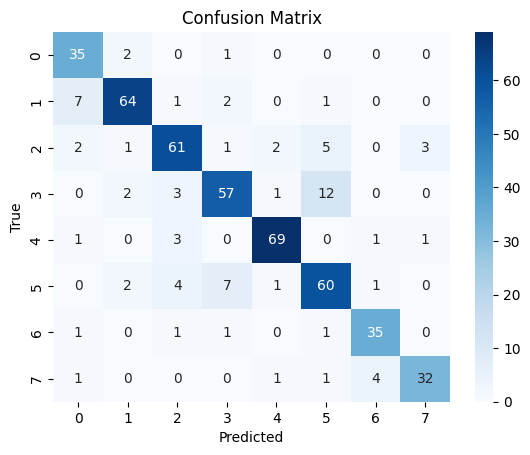

Class 0 Acc: 92.11%
Class 1 Acc: 85.33%
Class 2 Acc: 81.33%
Class 3 Acc: 76.00%
Class 4 Acc: 92.00%
Class 5 Acc: 80.00%
Class 6 Acc: 89.74%
Class 7 Acc: 82.05%


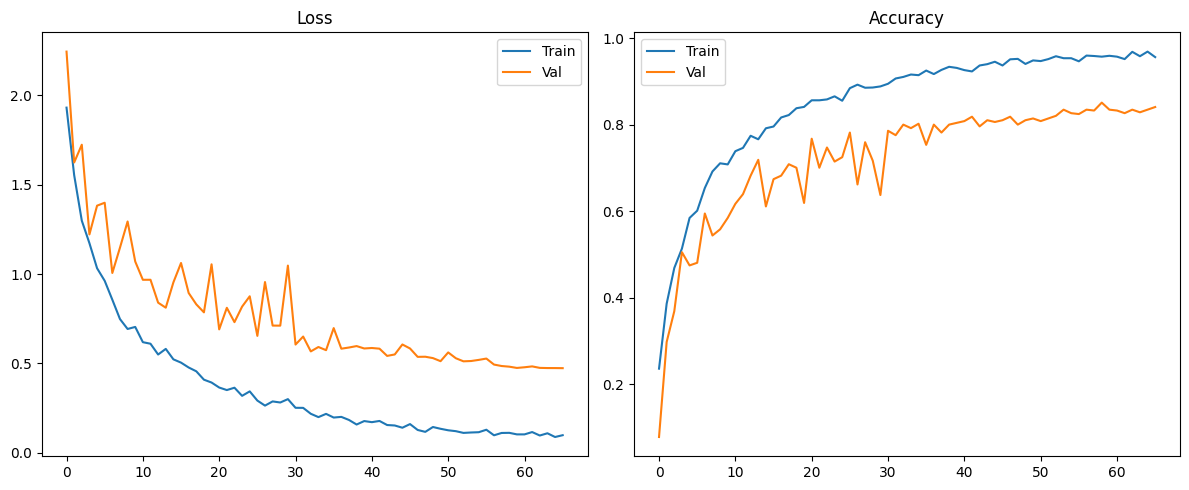

In [6]:
model = run_inception_pipeline(
    df,
    batch_size=64,
    lr=1e-4,
    epochs=70,
    oversample_boost={3: 2.5},
    use_focal=False
)
